# Preamble

In [14]:
# dependencies
import numpy as np
import os
import re
import sys
import glob
import collections
import pickle

from scipy.interpolate import interp1d
from scipy import optimize

import pandas as pd
from astropy.io import fits, ascii
import photoz_metrics

from astropy.table import Table, join

import matplotlib
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('text', usetex=True)

# plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')

# sns.set_style('darkgrid')

plt.rc('pdf',fonttype=42)
sns.mpl.rc('figure', figsize = (14, 8))
sns.set_context('notebook', font_scale=2.5, rc={'lines.linewidth': 2.5})

# options
# %matplotlib inline
# import matplotlib.pyplot as plt
# from matplotlib import rc

# rc('figure', figsize = (12, 8))
# rc('font',**{'size': 30, 'family':'serif', 'serif':['Palatino']})
# rc('text', usetex=True)

STILTS = 'java -Xmx2048M -jar /Users/coupon/local/bin/stilts.jar'
DATADIR = os.environ['HOME']+'/data/euclid/varTrans'
CURRENTDIR = '../'


# add ./python to python path
path_python = '../python'
if not path_python in sys.path:
    sys.path.insert(0, '../python')

import var_trans_utils as vtu

from importlib import reload

# Simulations



## The reference filter set



u 3679 -0.08 7.36
g 4842 0.21 9.68
r 6439 0.61 12.88
i 7821 0.96 15.64
z 9172 1.29 18.34
vis 7156 0.79 14.31
Y 10862 1.72 21.72
J 13685 2.42 27.37
H 17727 3.43 35.45


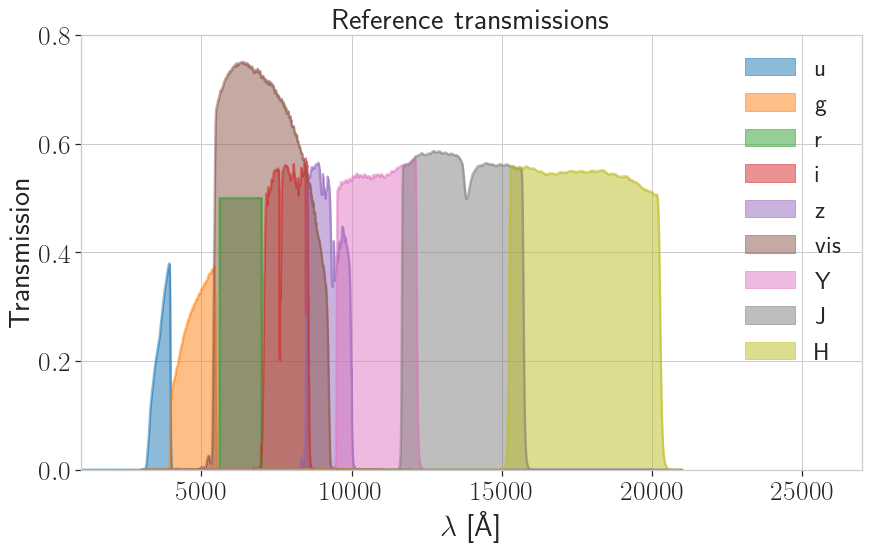

In [15]:
# location of Euclid filters
filter_dir = os.environ['HOME']+'/data/euclid/WP_testing/DC3/filters/final'

# read filter and put in data frames (df)
filter_ref_names = ['u', 'g', 'r', 'i', 'z', 'vis', 'Y', 'J', 'H']
filter_dfs = {}
for f in filter_ref_names:
    filter_dfs[f] = pd.read_csv(
        filter_dir+'/'+f+'.ascii',
        header=0, sep='\s+', 
        names=['lambda', f])

    norm = np.trapz(filter_dfs[f][f], filter_dfs[f]['lambda'])
    mean = np.trapz(
        filter_dfs[f]['lambda']*filter_dfs[f][f], filter_dfs[f]['lambda'])/norm
    z_Blamer = mean/4000.0-1
    print('{} {:.0f} {:.2f} {:.2f}'.format(f, mean, z_Blamer, 0.002*(1+z_Blamer)*4000.))


# replace r filter with top hat
filter_dfs['r'] = pd.DataFrame(vtu.create_r_top_hat_trans('r', top = 0.50))
filter_dfs['r'].rename(columns={'trans': 'r'}, inplace=True)

# plot filters
fig, ax = plt.subplots()
for f in filter_ref_names:
    filter_dfs[f].plot.area(
        x='lambda', stacked=False, 
        title='Reference transmissions', 
        ax=ax,)
    ax.set_xlabel(r'$\lambda$ [\AA{}]')
    ax.set_ylabel('Transmission')

# adjust plot
ax.set_ylim([0.0,0.8])
ax.set_xlim([1000,27000])
plt.legend(loc='upper right', fontsize='small') #, bbox_to_anchor=(1.0, 1.0))

fig.savefig('../plots/reference_filters.pdf')

# write reference filter transmissions
output_dir = CURRENTDIR+'/filters/ref'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for f in filter_ref_names:
    filter_dfs[f].to_csv(output_dir+'/'+f+'.ascii', columns=['lambda', f], 
                 sep=' ', index=False, header=False)   